# FFF from UltraFastBert experiments

In [ ]:
#|hide
import nbdev
import math
import torch
import FastFF.imports.ultrafastbert as ufb
from FastFF.utils import *
from FastFF.activations import *
import torchvision.transforms as T
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch import tensor
from torchvision.datasets import MNIST
import wandb
from fastai.vision.all import *
from fastai.callback.wandb import *

In [ ]:
#|hide
train, test = get_mnist_dls()

In [ ]:
class FFF2DistCB(ProbsDistrCB):
    def before_fit(self): 
        super().before_fit()
        # self.depth = getattr(self.module, 'depth', None)
        self.total_leaves = 2**self.depth

    def after_batch(self): 
        if self.training: 
            if self.wandb:  self._wandb_step += 1
            leaves = (self.module.decision_map * torch.linspace(0,1,2*self.total_leaves-1)).argmax(2)-self.total_leaves+1
            self.tree_leaves.append(leaves)
            self.preds.append(self.pred.argmax(1))
            self.xs.append(self.xb[0]), self.ys.append(self.yb[0])
    
    def leaf_hist(self, epoch_idx, tree_idx=0, ax=None, show=True,):
        leaves, lbls = self.data[epoch_idx][2][:,tree_idx], self.data[epoch_idx][1]
        if not self.total_leaves: self.total_leaves = leaves.unique().max()+1
        if not ax: ax = subplots()[1][0]
        bottom, bins = torch.zeros(self.total_leaves), L(range(self.total_leaves)).map(str)
        for d in range(10):
            hist = torch.bincount(leaves[lbls==d], minlength=self.total_leaves)
            ax.bar(bins, hist, label=str(d),bottom=bottom)
            bottom += hist
        if show: 
             ax.legend(); plt.show()

In [ ]:
class GetGradsCB(Callback):
    def before_fit(self): self.grads = []
    def after_fit(self): self.grads = torch.stack(self.grads)
    
    def after_backward(self):
        grad = self.model.linear_in.weight.grad.view(self.model.parallel_size,-1, 784)
        self.grads.append(grad.detach().abs().mean(dim=-1))

    def show(self, tree_idx=0, ax=None, figsize=(8,6)):
        if not ax: ax = subplots(figsize=figsize)[1][0]
        for i in range(self.grads.shape[-1]): ax.plot(self.grads[:,tree_idx,i],label=i)
        ax.legend()

In [ ]:
bs = 256
d = 2
n_trees = 32

In [ ]:
#|hide
#|eval: false
model_fff = ufb.FFF(28*28, 10, d, n_trees, activation=nn.PReLU)
dls = DataLoaders(TfmdDL(train, bs, True),TfmdDL(test, bs, False))
learn = Learner(dls, model_fff, loss_func=F.cross_entropy, metrics=accuracy)
cbs = [FFF2DistCB(sample_size=10), GetGradsCB()]
learn.fit_one_cycle(15, lr_max=2e-2, cbs=cbs);

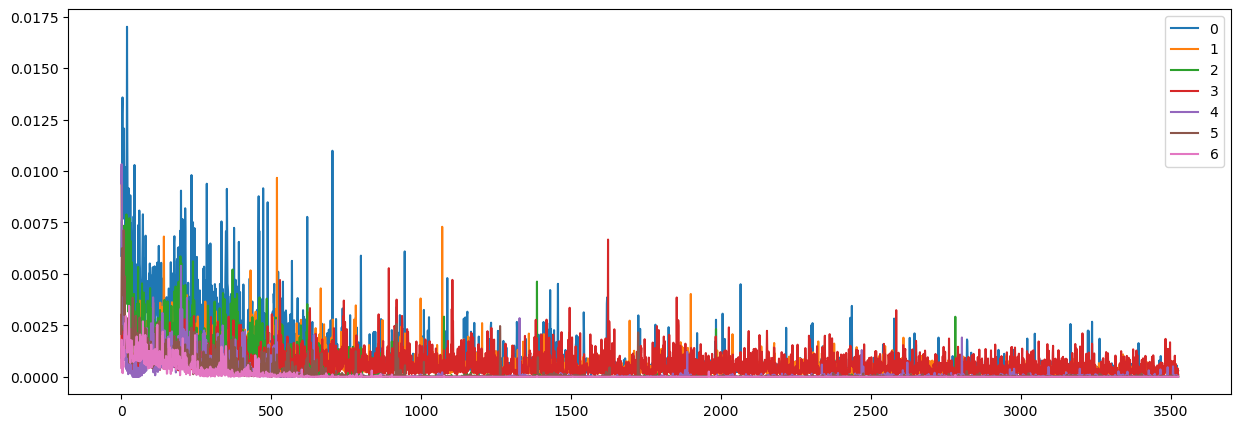

In [ ]:
#|eval: false
ax = subplots(figsize=(15,5))[1][0]
cbs[1].show(ax=ax)

<matplotlib.legend.Legend>

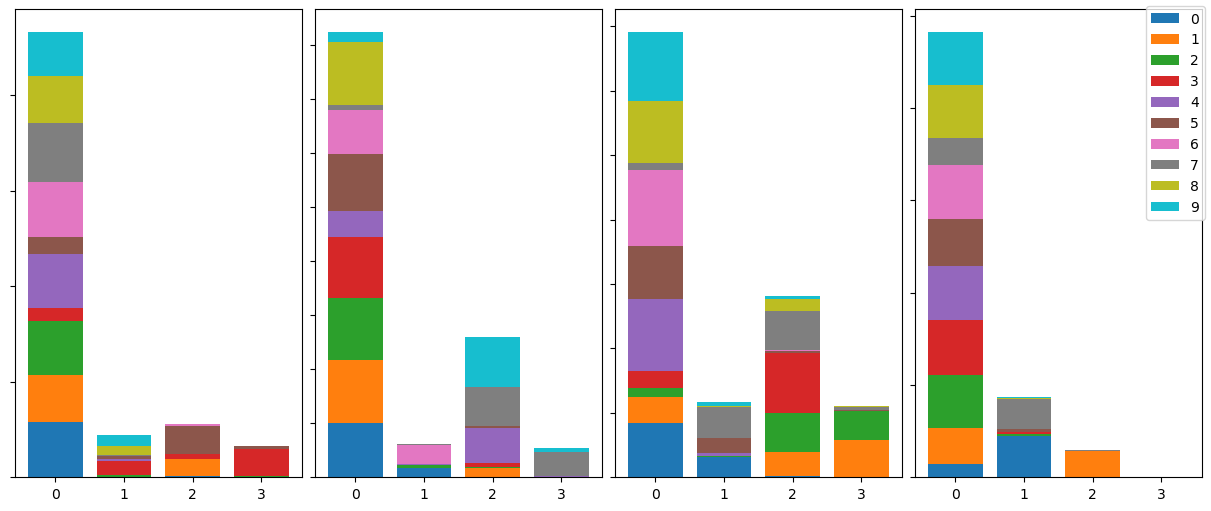

In [ ]:
#|eval: false
tree = 2
n_epoch = n_trees
ncols = 4
fig, axes = subplots(ncols=ncols, nrows=math.ceil(n_epoch/ncols),
                     figsize=(12,5), layout="constrained")
for i in range(n_epoch):
        ax =  axes[i//ncols][i%ncols] if math.ceil(n_epoch/ncols)>1 else axes[i%ncols]
        ax.set_yticklabels([])
        cbs[0].leaf_hist(tree, i, ax=ax, show=False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)